# Publication-Quality SED Visualization

This notebook creates journal-ready plots showing how Spectral Energy Distributions (SEDs) vary across different grain sizes and interstellar environments.

**Scenarios compared:**
1. **Minimum grain size** ($a_{\text{min}}$) in **molecular cloud** environments
2. **Maximum grain size** ($a_{\text{max}}$) in **molecular cloud** environments  
3. **Minimum grain size** ($a_{\text{min}}$) in **diffuse ISM** environments
4. **Maximum grain size** ($a_{\text{max}}$) in **diffuse ISM** environments

In [35]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from matplotlib.colors import to_rgba
import warnings
warnings.filterwarnings('ignore')

# Add the root directory of the package to sys.path
sys.path.append('/Users/zzhang/Workspace/SpyDust/')
sys.path.append('../')

In [36]:
# Configure matplotlib for publication quality
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'Bitstream Vera Serif', 'serif'],
    'text.usetex': False,  # Set to True if LaTeX is available
    'figure.figsize': [10, 8],
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.format': 'pdf',
    'axes.linewidth': 1.2,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 6
})

In [37]:
# Check which font is actually being used
import matplotlib.font_manager as fm
font_prop = fm.FontProperties(family='serif')
print(f"Active serif font: {font_prop.get_name()}")
print(f"Available serif fonts: {[f.name for f in fm.fontManager.ttflist if 'serif' in f.name.lower()][:5]}")  # Show first 5

Active serif font: Times New Roman
Available serif fonts: ['DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif Display', 'DejaVu Serif']


In [38]:
# Import SpyDust modules
import functools
import SpyDust.Grain as Grain
from SpyDust.SpyDust import SpyDust_given_grain_size_shape
from SpyDust.util import makelogtab, cgsconst
from SpyDust.SPDUST_as_is import emissivity
import matplotlib.cm as cm


In [49]:
a_min=3.5e-8
a_max=3.5e-7
d=3.35e-8
a2=6.0e-8
# a2=a_max


def spdust_SED_given_grain(env, a, tumbling=True):
        # Determine the dipole moment
    mu_1d_7 = env['dipole']
    dipole_mom = mu_1d_7 / np.sqrt(Grain.N_C(1e-7) + Grain.N_H(1e-7)) * cgsconst.debye
    ip=2./3.
    result=emissivity.dP_dnu_dOmega(env, a, dipole_mom,ip, 20, tumbling=tumbling)
    return result

# Define environment classes (copied from main notebook)
class molecular_cloud:
    def __init__(self, num=10, a_val=3.5e-8, beta_val=-0.47):
        self.num = num
        self.a_val = a_val
        self.beta_val = beta_val
        self.nh_list = makelogtab(1e4, 3e2, num)
        self.T = makelogtab(10, 20, num)
        self.Chi = makelogtab(1e-4, 1e-2, num)
        self.xh = np.zeros(num)
        self.xC = makelogtab(1e-6, 1e-4, num)
        self.y = makelogtab(0.999, 0.99, num)
    
    def generate_SED(self, env, a, beta, min_freq=0.1, max_freq=1000.0, n_freq=500):
        result = SpyDust_given_grain_size_shape(env, a, beta, 
                                                min_freq=min_freq, max_freq=max_freq, n_freq=n_freq,
                                                N_angular_Omega=800,
                                                a2=a2)
        return result[0], result[1]
    
    def analysis(self, min_freq=0.1, max_freq=1000.0, n_freq=500):
        result = []
        freq = []

        for i in range(self.num):
            env = {'nh': self.nh_list[i], 'T': self.T[i], 'Chi': self.Chi[i], 
                   'xh': self.xh[i], 'xC': self.xC[i], 'y': self.y[i], 
                   'gamma': 0, 'dipole': 9.3, 'line': 7}
            
            freq, result_SED = self.generate_SED(env, 
                                                    a=self.a_val, 
                                                    beta=self.beta_val,
                                                    min_freq=min_freq, max_freq=max_freq, n_freq=n_freq
                                                    )

            result.append(result_SED)
        return freq, result

class diffuse_neutral_ISM(molecular_cloud):
    def __init__(self, num=10, a_val=3.5e-8, beta_val=-0.47):
        super().__init__(num=num, a_val=a_val, beta_val=beta_val)
        self.nh_list = makelogtab(30, 0.1, num)
        self.T = makelogtab(100, 8000, num)
        self.Chi = np.ones(num)
        self.xh = makelogtab(0.0012, 0.99, num)
        self.xC = makelogtab(0.0003, 0.001, num)
        self.y = np.zeros(num)

class diffuse_ionised_ISM(molecular_cloud):
    def __init__(self, num=10, a_val=3.5e-8, beta_val=-0.44):
        super().__init__(num=num, a_val=a_val, beta_val=beta_val)
        self.nh_list = makelogtab(1e4, 10, num)
        self.T = makelogtab(8000, 15000, num)
        self.Chi = makelogtab(1e3, 1e4, num)
        self.xh = makelogtab(0.99, 0.999, num)
        self.xC = makelogtab(1e-5, 1e-3, num)
        self.y = np.zeros(num)

In [50]:
a_val = 4e-8
d=3.35e-8
beta_val = Grain.cylindrical_params(a_val, d)[1]
print(f"Using beta value: {beta_val:.4f} for a={a_val:.2e} cm and d={d:.2e} cm")

Using beta value: -0.4266 for a=4.00e-08 cm and d=3.35e-08 cm


In [51]:

# Generate SED data (this may take some time)
print("Computing SEDs for molecular cloud environments...")
test_molecular_gas = molecular_cloud(num=100, a_val=a_val, beta_val=beta_val)
freq_mole, SED_mole_envs = test_molecular_gas.analysis(max_freq=100)

# print("Computing SEDs for diffuse neutral ISM environments...")
# test_diffuse_neutral = diffuse_neutral_ISM(num=100, a_val=a_val, beta_val=beta_val)
# freq_neum, SED_neum_envs = test_diffuse_neutral.analysis(max_freq=100)

print("Computing SEDs for diffuse ionised ISM environments...")
test_diffuse_ionised = diffuse_ionised_ISM(num=100, a_val=a_val, beta_val=beta_val)
freq_ion, SED_ion_envs = test_diffuse_ionised.analysis(max_freq=1200)

Computing SEDs for molecular cloud environments...
Computing SEDs for diffuse ionised ISM environments...
Computing SEDs for diffuse ionised ISM environments...


In [ ]:
from SpyDust.SED_fit import fit_sed_ensemble

SED_mole_envs = np.array(SED_mole_envs)
SED_ion_envs = np.array(SED_ion_envs)

features_mole =  fit_sed_ensemble(freq_mole, SED_mole_envs, thres=1e-3)
features_ion =  fit_sed_ensemble(freq_ion, SED_ion_envs, thres=1e-3)

100%|██████████| 100/100 [00:00<00:00, 5495.75it/s]


(100, 2)

## Figure: Multi-Panel Detailed Comparison

This figure uses a 2×2 grid to show each scenario separately, making it easier to see the detailed structure of each SED type.

In [53]:
# Define color scheme for different scenarios
colors = {
    'c1': '#1f77b4',      # Blue for molecular cloud, minimum grain size  
    'c2': '#ff7f0e',      # Orange for molecular cloud, maximum grain size
    'c3': '#2ca02c',   # Green for diffuse ISM, minimum grain size
    'c4': '#d62728',   # Red for diffuse ISM, maximum grain size
    'c5': '#9467bd',         # Purple - additional color 1
    'c6': '#8c564b',         # Brown - additional color 2
}

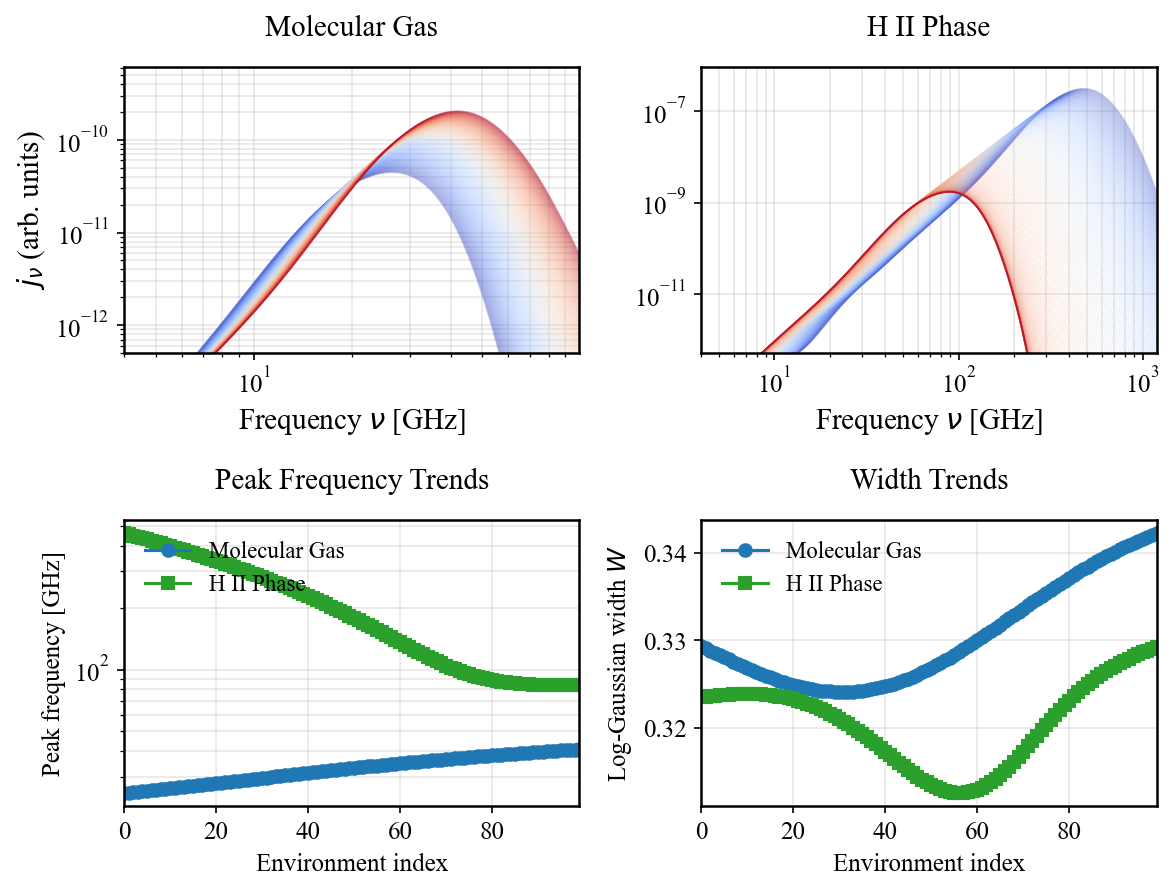

In [54]:
# Create multi-panel detailed figure with shared axes
fig, axes = plt.subplots(2, 2, figsize=(8, 6), 
                        # sharex='col', sharey='col'
                        )
axes = axes.flatten()

# Define panel data and labels
panels = [
    (freq_mole, SED_mole_envs, colors['c1'], 
     'Molecular Gas'),
    (freq_ion, SED_ion_envs, colors['c3'], 
     'H II Phase'),
]

peak_freqs_mole = np.exp(features_mole[:, 0])
peak_freqs_ion = np.exp(features_ion[:, 0])
width_mole = features_mole[:, 1]
width_ion = features_ion[:, 1]

for i, (freq, sed_data, color, title) in enumerate(panels):
    ax = axes[i]
    
    # Normalize all SEDs to peak = 1
    normalized_seds = []
    for j in range(len(sed_data)):
        if np.max(sed_data[j]) > 0:
            # sed_norm = sed_data[j] / np.max(sed_data[j])
            sed_norm = sed_data[j]
            normalized_seds.append(sed_norm)
    
    normalized_seds = np.array(normalized_seds)
    
    # Calculate statistics for shaded regions
    sed_clean = np.where(normalized_seds <= 0, np.nan, normalized_seds)
    mean_sed = np.nanmean(sed_clean, axis=0)
    # median_sed = np.nanmedian(sed_clean, axis=0)
    # p16_sed = np.nanpercentile(sed_clean, 16, axis=0)
    # p84_sed = np.nanpercentile(sed_clean, 84, axis=0)
    # p05_sed = np.nanpercentile(sed_clean, 5, axis=0)
    # p95_sed = np.nanpercentile(sed_clean, 95, axis=0)
    
    # # Plot shaded confidence regions
    # ax.fill_between(freq, p05_sed, p95_sed, 
    #                color=color, alpha=0.15, label='90% conf. interval')
    # ax.fill_between(freq, p16_sed, p84_sed, 
    #                color=color, alpha=0.3, label='68% conf. interval')
    
    n_seds = len(normalized_seds)
    cmap = cm.get_cmap('coolwarm')  # Or try 'plasma', 'coolwarm', 'tab10', etc.

    for j in range(n_seds):
        SED = normalized_seds[j]
        # freq = freqs[j]
        # alpha_value = 0.1 + 0.4 * (j / n_seds)  # Alpha varies from 0.1 to 0.5
        # color = to_rgba(color, alpha=alpha_value)
        color_val = j / (n_seds - 1) if n_seds > 1 else 0
        color = cmap(color_val)
        ax.loglog(freq, SED, color=color, alpha=0.3, linewidth=0.8)
    
    # # Plot median line
    # ax.loglog(freq, median_sed, color=color, linewidth=3, 
    #          label='Median SED')
    
    # Plot mean line
    # ax.loglog(freq, mean_sed, color='black', linewidth=2, 
    #          label='Mean SED', linestyle='--', alpha=0.8)
    
    # Formatting
    ax.set_title(title, fontsize=14, pad=15)
    ax.grid(True, alpha=0.3, which='both')
    
    # Labels only for bottom and left panels (shared axes handle the rest)
    # if i >= 3:  # Bottom row
    ax.set_xlabel(r'Frequency $\nu$ [GHz]', fontsize=14)
    if i % 3 == 0:  # Left column
        ax.set_ylabel(r'$j_\nu$ (arb. units)', fontsize=14)
    
    # Set consistent axis limits: 3 orders of magnitude
    ax.set_xlim(4, freq[-1])
    ymax = 3. * normalized_seds.max()
    ax.set_ylim(5e-13, ymax)  # Three orders of magnitude with peak at 1
    # ax.set_xlim(1e9, 5e11)
    # ax.set_ylim(1e-40, 6e-35)
    
    # Add legend to all panels with compact formatting
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(loc='upper left', fontsize=12, frameon=False, 
                 fancybox=True, shadow=True, framealpha=0.9,
                #  bbox_to_anchor=(0.98, 0.98)
                 )

# Panel 3: peak frequency trends
ax_freq = axes[2]
env_idx_mole = np.arange(len(peak_freqs_mole))
env_idx_ion = np.arange(len(peak_freqs_ion))
ax_freq.plot(env_idx_mole, peak_freqs_mole, color=colors['c1'], marker='o', linewidth=1.5,
             label='Molecular Gas')
ax_freq.plot(env_idx_ion, peak_freqs_ion, color=colors['c3'], marker='s', linewidth=1.5,
             label='H II Phase')
ax_freq.set_xlabel('Environment index', fontsize=12)
ax_freq.set_ylabel('Peak frequency [GHz]', fontsize=12)
ax_freq.set_title('Peak Frequency Trends', fontsize=14, pad=15)
ax_freq.set_yscale('log')
ax_freq.set_xlim(0, max(env_idx_mole[-1], env_idx_ion[-1]))
ax_freq.grid(True, alpha=0.3, which='both')
ax_freq.legend(loc='upper left', fontsize=11, frameon=False)

# Panel 4: width trends
ax_width = axes[3]
ax_width.plot(env_idx_mole, width_mole, color=colors['c1'], marker='o', linewidth=1.5,
              label='Molecular Gas')
ax_width.plot(env_idx_ion, width_ion, color=colors['c3'], marker='s', linewidth=1.5,
              label='H II Phase')
ax_width.set_xlabel('Environment index', fontsize=12)
ax_width.set_ylabel('Log-Gaussian width $W$', fontsize=12)
ax_width.set_title('Width Trends', fontsize=14, pad=15)
ax_width.set_xlim(0, max(env_idx_mole[-1], env_idx_ion[-1]))
ax_width.grid(True, alpha=0.3, which='both')
ax_width.legend(loc='upper left', fontsize=11, frameon=False)

# Add overall title
# fig.suptitle('Normalized Detailed SED Comparison: Environment and Grain Size Effects', 
#              fontsize=18, y=0.98)



plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('SED_multipanel_env.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [47]:
MC_params = {'nh' : 3e2, 'T': 20., 'Chi': 1e-2, 'xh': 0., 'xC': 1e-4, 'y' : 0.99,  'gamma': 0, 'dipole': 9.3}    
# WIM_params = {'nh' : 0.1, 'T': 8000., 'Chi': 1., 'xh': 0.99, 'xC': 1e-3, 'y' : 0, 'gamma': 0, 'dipole': 9.3}
# CNM_params = {'nh' : 30, 'T': 100., 'Chi': 1, 'xh': 1.2e-3, 'xC': 3e-4, 'y' : 0, 'gamma': 0, 'dipole': 9.3, 'line':7}
# DC_params = {'nh' : 1e4, 'T': 10., 'Chi': 1e-4, 'xh': 0., 'xC': 1e-6, 'y' : 0.999,  'gamma': 0, 'dipole': 9.3, 'line':7}
# Hii_params = {'nh' : 1e4, 'T': 1e4, 'Chi': 1e4, 'xh': 0.999, 'xC': 1e-4, 'y' : 0,  'gamma': 0, 'dipole': 9.3, 'line':7}



def beta_val(a, d):
    if a<=a2:
        beta=Grain.cylindrical_params(a, d)[1]
    else:
        beta=0.
    return beta

Num_beta=60
# beta_tab_disk = np.linspace(-0.48, -0.2, Num_beta)
# beta_tab_ellip = np.linspace(-0.2, 0.2, Num_beta)

beta_tab  = np.linspace(-0.47, 0.5, Num_beta)

a_tab = makelogtab(a_min, a_max, 100)

MC_sed_tumbling_varying_a = []
MC_sed_tumbling_varying_beta = []

# DC_sed_disk = []
# CNM_sed_disk = []
# WIM_sed_disk = []
# Hii_sed_disk = []

# MC_sed_sphere = []
# DC_sed_sphere = []
# CNM_sed_sphere = []
# WIM_sed_sphere = []

for a in a_tab:
    beta = -0.2
    # frequency, DC_sed = SpyDust_given_grain_size_shape(DC_params, a, beta, 
    #                                         min_freq=0.1, max_freq=100.0, n_freq=200,
    #                                         N_angular_Omega=500,
    #                                         a2=a2)
    frequency, MC_sed = SpyDust_given_grain_size_shape(MC_params, a, beta, 
                                            min_freq=0.1, max_freq=100.0, n_freq=200,
                                            N_angular_Omega=500,
                                            a2=a2)
    
    # beta = 0.0
    # frequency, MC_sed_e = SpyDust_given_grain_size_shape(MC_params, a, beta, 
    #                                         min_freq=0.1, max_freq=100.0, n_freq=200,
    #                                         N_angular_Omega=500,
    #                                         a2=a_min)
    
    # frequency_Hii, Hii_sed = SpyDust_given_grain_size_shape(Hii_params, a, beta, 
    #                                         min_freq=1, max_freq=1000.0, n_freq=200,
    #                                         N_angular_Omega=500,
    #                                         a2=a2)
    MC_sed_tumbling_varying_a.append(MC_sed)
    # DC_sed_disk.append(DC_sed)
    # Hii_sed_disk.append(Hii_sed)



for beta in beta_tab:
    a = 4e-8

    frequency, MC_sed = SpyDust_given_grain_size_shape(MC_params, a, beta,
                                            min_freq=0.1, max_freq=100.0, n_freq=200,
                                            N_angular_Omega=500,
                                            a2=a2)
    MC_sed_tumbling_varying_beta.append(MC_sed)


MC_sed_varying_a = np.array(MC_sed_tumbling_varying_a)
MC_sed_varying_beta = np.array(MC_sed_tumbling_varying_beta)

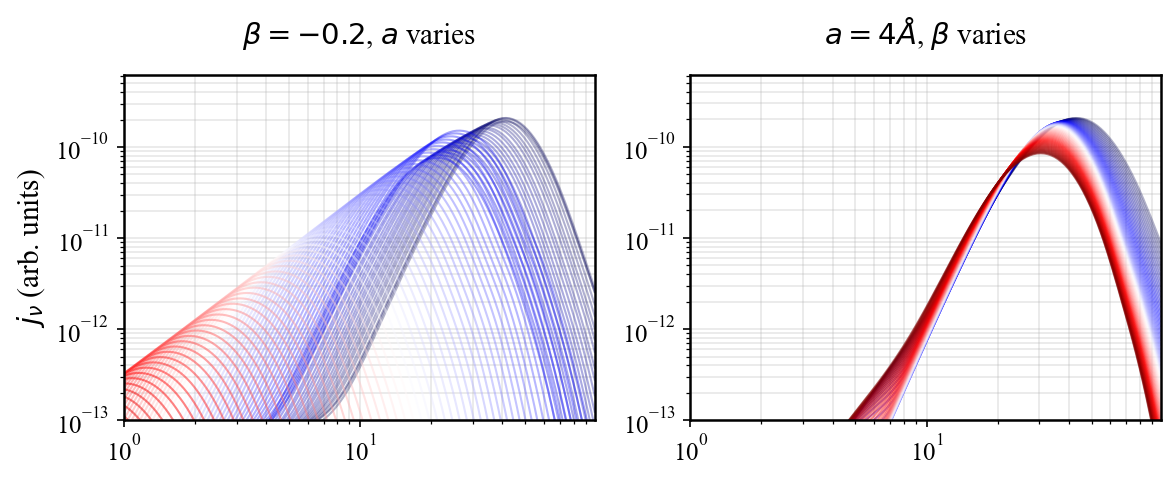

In [48]:

# Create multi-panel detailed figure with shared axes
fig, axes = plt.subplots(1, 2, figsize=(8, 3), 
                        # sharex='col', sharey='row'
                        )
axes = axes.flatten()

# Define panel data and labels
panels = [
    (MC_sed_varying_a, colors['c1'], 
     r'$\beta=-0.2$, $a$ varies'),
    (MC_sed_varying_beta, colors['c2'], 
     r'$a= 4 \AA$, $\beta$ varies'),
]

for i, (sed_data, color, title) in enumerate(panels):
    ax = axes[i]

    freq=frequency
    
    normalized_seds = []
    for j in range(len(sed_data)):
        if np.max(sed_data[j]) > 0:
            sed_norm = sed_data[j]
            normalized_seds.append(sed_norm)
    
    normalized_seds = np.array(normalized_seds)
    
    # Calculate statistics for shaded regions
    # sed_clean = np.where(normalized_seds <= 0, np.nan, normalized_seds)
    # mean_sed = np.nanmean(sed_clean, axis=0)
    # median_sed = np.nanmedian(sed_clean, axis=0)
    # p16_sed = np.nanpercentile(sed_clean, 16, axis=0)
    # p84_sed = np.nanpercentile(sed_clean, 84, axis=0)
    # p05_sed = np.nanpercentile(sed_clean, 5, axis=0)
    # p95_sed = np.nanpercentile(sed_clean, 95, axis=0)
    
    # # Plot shaded confidence regions
    # ax.fill_between(freq, p05_sed, p95_sed, 
    #                color=color, alpha=0.15, label='90% conf. interval')
    # ax.fill_between(freq, p16_sed, p84_sed, 
    #                color=color, alpha=0.3, label='68% conf. interval')
    
    # Plot individual SEDs with varying colors
    # n_seds = len(normalized_seds)
    # for j, SED in enumerate(normalized_seds):
    #     # Create a color gradient from light to dark version of the base color
    #     alpha_value = 0.1 + 0.4 * (j / n_seds)  # Alpha varies from 0.1 to 0.5
    #     varying_color = to_rgba(color, alpha=alpha_value)
    #     ax.loglog(freq, SED, color=varying_color, linewidth=0.8)

    # Plot individual SEDs with colormap variation
    n_seds = len(normalized_seds)
    cmap = cm.get_cmap('seismic')  # Or try 'plasma', 'coolwarm', 'tab10', etc.

    for j, SED in enumerate(normalized_seds):
        # Use colormap to vary colors across the spectrum
        color_val = j / (n_seds - 1) if n_seds > 1 else 0
        line_color = cmap(color_val)
        alpha_val = j / (4*n_seds) + 0.3
        ax.loglog(freq, SED, color=line_color, alpha=alpha_val, linewidth=1)
        # ax.loglog(freq, SED, color=color, alpha=0.2, linewidth=0.8)
    
    # # Plot median line
    # ax.loglog(freq, median_sed, color=color, linewidth=3, 
    #          label='Median SED')
    
    # Plot mean line
    # ax.loglog(freq, mean_sed, color='black', linewidth=2, 
    #          label='Mean SED', linestyle='--', alpha=0.8)
    
    # Formatting
    ax.set_title(title, fontsize=14, pad=15)
    ax.grid(True, alpha=0.3, which='both')
    
    # Labels only for bottom and left panels (shared axes handle the rest)
    if i >= 2:  # Bottom row
        ax.set_xlabel(r'Frequency $\nu$ [GHz]', fontsize=14)
    if i % 2 == 0:  # Left column
        ax.set_ylabel(r'$j_\nu$ (arb. units)', fontsize=14)
    
    # Set consistent axis limits: 3 orders of magnitude
    # ax.set_xlim(freq[0], freq[-1])
    # ax.set_ylim(1e-13, 6e-10)  # Three orders of magnitude with peak at 1

    # Set consistent axis limits: 3 orders of magnitude
    ax.set_xlim(1, freq[-1])
    ymax = 3. * normalized_seds.max()
    ax.set_ylim(1e-13, ymax)  # Three orders of magnitude with peak at 1
    
    # Add legend to all panels with compact formatting
    ax.legend(loc='upper left', fontsize=12, frameon=False, 
             fancybox=True, shadow=True, framealpha=0.9,
            #  bbox_to_anchor=(0.98, 0.98)
             )

# Add overall title
# fig.suptitle('Normalized Detailed SED Comparison: Environment and Grain Size Effects', 
#              fontsize=18, y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('SED_multipanel_size_shape.pdf', dpi=300, bbox_inches='tight')
plt.show()